## LSTM + Attention

В качестве первого и простого решения рассмотрим сеть, где в энекодере и декодере будут использоваться рекурентные LSTM архитектуры. Плюс добавим attention механизм


In [ ]:
!pip install torchtext==0.11.0
!pip  install subword-nmt
!pip install wget

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import tqdm
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import pickle

In [ ]:
torchtext.__version__

'0.11.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
path_to_save_artifacts = '/content/drive/MyDrive/Made_nlp_hw/Made_NLP/'
sys.path.append(path_to_save_artifacts)
sys.path.append(path_to_save_artifacts + 'LSTM_Atten')
from data_preparation import DataPreparation
import utils
get_text = utils.get_text

### Prepare data

In [ ]:
dataclass = DataPreparation()

In [ ]:
train_data, valid_data, test_data = dataclass.data_pipeline()

download data
creating dataset
create train, valid and test data
Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500
build vocab
Unique tokens in source (ru) vocabulary: 9236
Unique tokens in target (en) vocabulary: 6696


### Create model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
from LSTM_Attention import prepare_model, train, evaluate

In [ ]:
INPUT_DIM = len(dataclass.SRC.vocab)
OUTPUT_DIM = len(dataclass.TRG.vocab)
model = prepare_model(device, INPUT_DIM, OUTPUT_DIM)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 24,224,808 trainable parameters


### Train model

In [ ]:
N_EPOCHS = 20
CLIP = 1
train_history = []
valid_history = []
bleu_history = []

best_valid_loss = float('inf')



lr = 1e-2
PAD_IDX = dataclass.TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)


for epoch in range(N_EPOCHS):   
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss, bleu = evaluate(model, valid_iterator, criterion, dataclass)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path_to_save_artifacts + 'LSTM_Atten/LSTM_ATTEN_weights.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    bleu_history.append(bleu)
    history_dict = {'bleu': bleu_history, 'train': train_history, 'valid': valid_history}
    with open( path_to_save_artifacts + 'LSTM_Atten/model_results.pkl', 'wb') as f:
      pickle.dump(history_dict, f)

    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | lr: {optimizer.param_groups[0]["lr"]}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | val. bleu: {bleu}')

    if epoch!=0:
      if (bleu_history[-1] - bleu_history[-2]) < 0.01:
        scheduler.step()
      elif epoch % 4 == 0:
        scheduler.step()
      else:
        pass



  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 4.275 | Train PPL:  71.860 | lr: 0.01
	 Val. Loss: 4.609 |  Val. PPL: 100.411 | val. bleu: 19.715885880442983


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 3.157 | Train PPL:  23.508 | lr: 0.01
	 Val. Loss: 4.491 |  Val. PPL:  89.208 | val. bleu: 22.74129716492186


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 2.955 | Train PPL:  19.197 | lr: 0.01
	 Val. Loss: 4.453 |  Val. PPL:  85.876 | val. bleu: 23.094365043824638


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 2.895 | Train PPL:  18.086 | lr: 0.01
	 Val. Loss: 4.572 |  Val. PPL:  96.725 | val. bleu: 23.177642020035112


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 2.797 | Train PPL:  16.390 | lr: 0.01
	 Val. Loss: 4.548 |  Val. PPL:  94.441 | val. bleu: 24.242647010612576


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 2.483 | Train PPL:  11.972 | lr: 0.001
	 Val. Loss: 4.464 |  Val. PPL:  86.829 | val. bleu: 26.657355827220336


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 2.369 | Train PPL:  10.688 | lr: 0.001
	 Val. Loss: 4.474 |  Val. PPL:  87.722 | val. bleu: 26.824502149175


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 2.303 | Train PPL:  10.008 | lr: 0.001
	 Val. Loss: 4.450 |  Val. PPL:  85.616 | val. bleu: 27.31288046830326


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 2.241 | Train PPL:   9.404 | lr: 0.001
	 Val. Loss: 4.441 |  Val. PPL:  84.891 | val. bleu: 27.814009993626193


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 2.192 | Train PPL:   8.950 | lr: 0.0001
	 Val. Loss: 4.436 |  Val. PPL:  84.466 | val. bleu: 27.74789838798732


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 2.185 | Train PPL:   8.895 | lr: 1e-05
	 Val. Loss: 4.441 |  Val. PPL:  84.897 | val. bleu: 27.705042929309787


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

	Train Loss: 2.160 | Train PPL:   8.675 | lr: 1.0000000000000002e-06
	 Val. Loss: 4.442 |  Val. PPL:  84.915 | val. bleu: 27.699878599247107


  0%|          | 0/625 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

### Load best model

In [ ]:
best_model = prepare_model(device, INPUT_DIM, OUTPUT_DIM)
best_model.load_state_dict(torch.load(path_to_save_artifacts + 'LSTM_Atten/LSTM_ATTEN_weights.pt'))
best_model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9236, 256)
    (rnn): LSTM(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(6696, 256)
    (rnn): LSTM(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=6696, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

## Check quality of network

Best translations

In [ ]:
import utils_for_attent

In [ ]:
losses, originals, generated_text = utils_for_attent.bad_and_good_translations(best_model, test_iterator, criterion, dataclass.TRG.vocab)

  0%|          | 0/118 [00:00<?, ?it/s]

In [ ]:
idx_of_good = np.array(losses).argmin()
print('Good translation:')
for i in range(5):
  print('Original: {}'.format(' '.join(originals[idx_of_good][i])))
  print('Generated: {}'.format(' '.join(generated_text[idx_of_good][i])))

Good translation:
Original: some rooms have a seating area to relax in after a busy day .
Generated: certain rooms feature a seating area where you can relax .
Original: certain rooms have a seating area for your convenience .
Generated: certain rooms feature a seating area where you can relax .
Original: guest rooms at the hotel pont royal are air - conditioned .
Generated: royal royal ascot offers royal air air conditioned rooms .
Original: all rooms are equipped with a shared bathroom equipped with a bath .
Generated: the bathroom comes with a bathtub .
Original: you can enjoy pool view .
Generated: you can enjoy pool view from the room .


Worst translations

In [ ]:
idx_of_bad = np.array(losses).argmax()
print('Bad translation:')
for i in range(5):
  print('Original: {}'.format(' '.join(originals[idx_of_bad][i])))
  print('Generated: {}'.format(' '.join(generated_text[idx_of_bad][i])))

Bad translation:
Original: situated a 15 minute walk from the blue beach on the gdańsk bay and 1 . 8 km from ergo arena , apartament offers pet - friendly accommodation in gdańsk . the apartment is 1 . 9 km from hall and 5 minute walk from the seaside ronald reagan park .
Generated: located in , apartment offers pet - friendly accommodation in , a 15 - minute walk from , 1 . 9 km from .
Original: enjoy the loch - view restaurant and bar and the residents lounge . the inn is ideally located for , , , ben , fort william , , , , loch and for the west highlands .
Generated: the restaurant and a restaurant , the view of the and the , the .
Original: novo rio bus station is 10 . 4 km from copacabana 2 , while santos dumont domestic airport is 8 . 5 km away . maracanã stadium is at a distance of 15 km and galeão international airport is located 25 . 7 km away .
Generated: rio bus station is 10 . 4 km from apartment on , while is is . 8 km from the property .
Original: visitors arriving to the

Test BLEU

In [ ]:
original_text = []
generated_text = []
best_model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = best_model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, dataclass.TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, dataclass.TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

118it [00:16,  7.00it/s]


In [ ]:
print('BLEU on test data:', corpus_bleu([[text] for text in original_text], generated_text) * 100)

BLEU on test data: 27.60946524864647


In [ ]:
with open(path_to_save_artifacts + 'LSTM_Atten/model_results.pkl', 'rb') as f:
    history_dict = pickle.load(f)

In [ ]:
bleu = history_dict['bleu']
train_losses = history_dict['train']
valid_losses = history_dict['valid']

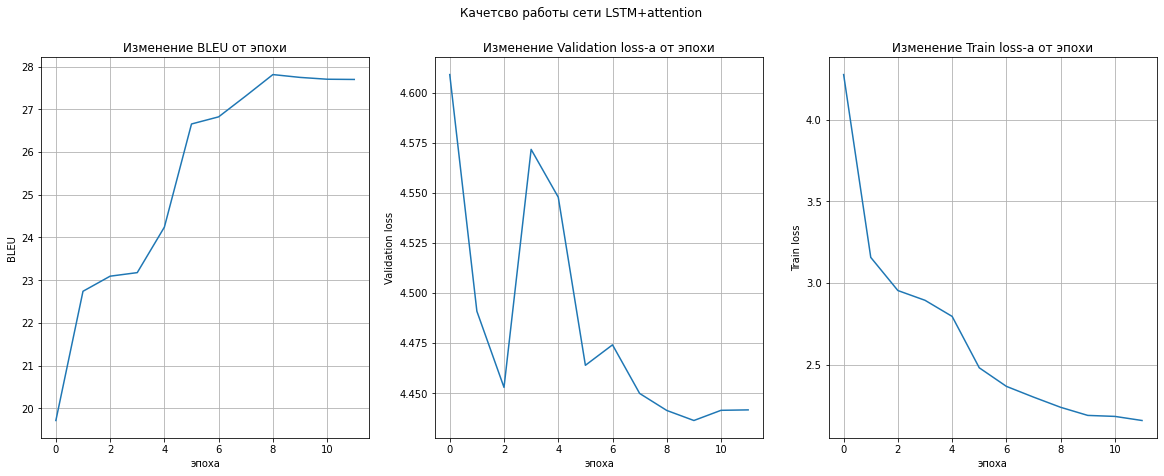

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (20,7))
fig.suptitle('Качетсво работы сети LSTM+attention')
axs[0].set_title('Изменение BLEU от эпохи')
axs[0].set_xlabel('эпоха')
axs[0].set_ylabel('BLEU')
axs[0].grid()
axs[0].plot(range(len(bleu)), bleu)

axs[1].set_title('Изменение Validation loss-a от эпохи')
axs[1].set_xlabel('эпоха')
axs[1].set_ylabel('Validation loss')
axs[1].grid()
axs[1].plot(range(len(valid_losses)), valid_losses)

axs[2].set_title('Изменение Train loss-a от эпохи')
axs[2].set_xlabel('эпоха')
axs[2].set_ylabel('Train loss')
axs[2].grid()
axs[2].plot(range(len(train_losses)), train_losses)
plt.show();

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

# Краткий обзор

В данном случае это было самое простое решение, с небольшой доработкой в виде attention механизма. Для инициализации весов решил использовать xavier распределение, это ускоряло схождение сети. При обучении был использован шедуллер. Полученное качество проходит порог указанный в ноутбуке. Лучшие переводы показывают, что модель действительно обучилась переводить не очень качетственно, но смысл сохраняется. Однако, плохие переводы показывают, что еще есть куда расти. Серьезного переобучения не наступило, конечно, метрки на train лучше, но генерализационная способность у сети есть.

### Метрики: 
Train Loss: 2.160 | Train PPL:   8.675
	 
Val. Loss: 4.442 |  Val. PPL:  84.915 | val. bleu: 27.699878599247107

BLEU on test data: 27.60946524864647

### Хорошие и плохие переводы преставлены выше.
### Графики обучения также предствалены выше.
### Скорость обучения:
9 минут на эпоху, где батч = 64, а треин корпус состоит из 40000 примеров
### Cкорость инференса:

CPU times: user 50.1 ms, sys: 1.22 ms, total: 51.3 ms
Wall time: 53.8 ms
На батч из 32